In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# 1. Đọc dữ liệu

In [15]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# 2. Kiểm tra dữ liệu

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [17]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [18]:
df.duplicated().sum()

0

Ta thấy data không bị duplicated hoặc missing

# 3. Xác định biến phân loại và biến số

In [19]:
X = df[['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
num_cols = ['Annual Income (k$)', 'Spending Score (1-100)', 'Age']
cat_cols = ['Gender']

Kiểm tra correlation giữa các biến số => không có sự liên hệ giữa các biến số

<Axes: >

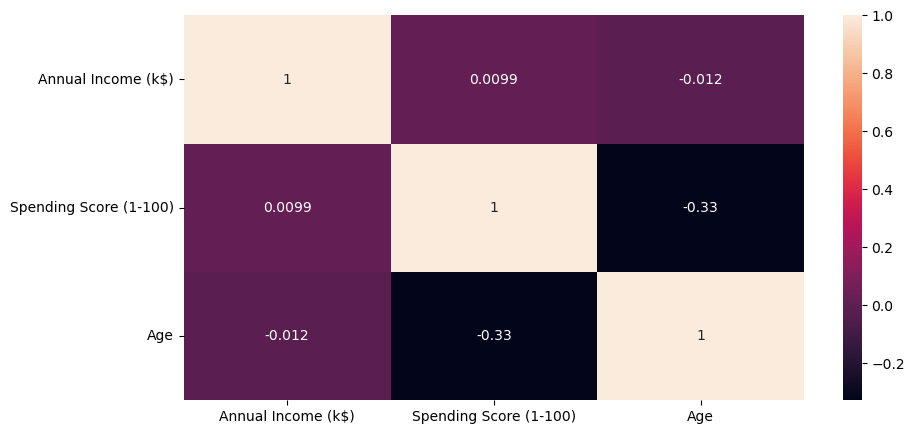

In [21]:
plt.figure(figsize=(10,5))
sns.heatmap(X[num_cols].corr(), annot=True)
plt.title('Correlation between numerical variables')

Kiểm tra phân phối của các biến số

== Column name: Annual Income (k$)
Median: 61.5
Mean: 60.56
Annual Income (k$) doesn't follow normal distribution


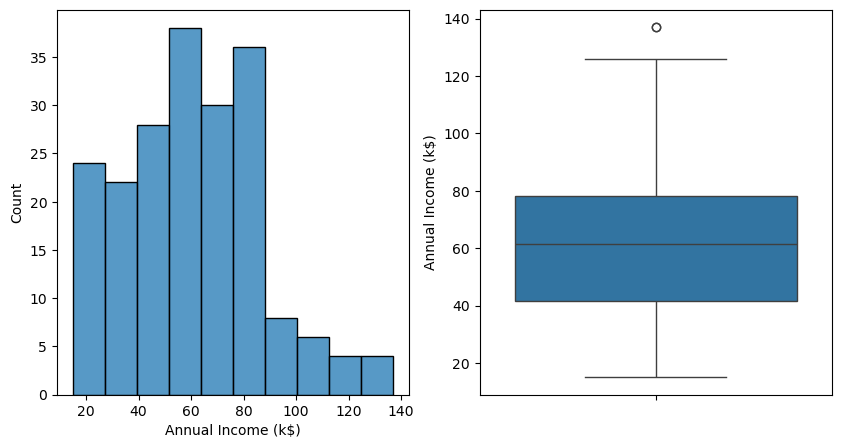

== Column name: Spending Score (1-100)
Median: 50.0
Mean: 50.2
Spending Score (1-100) doesn't follow normal distribution


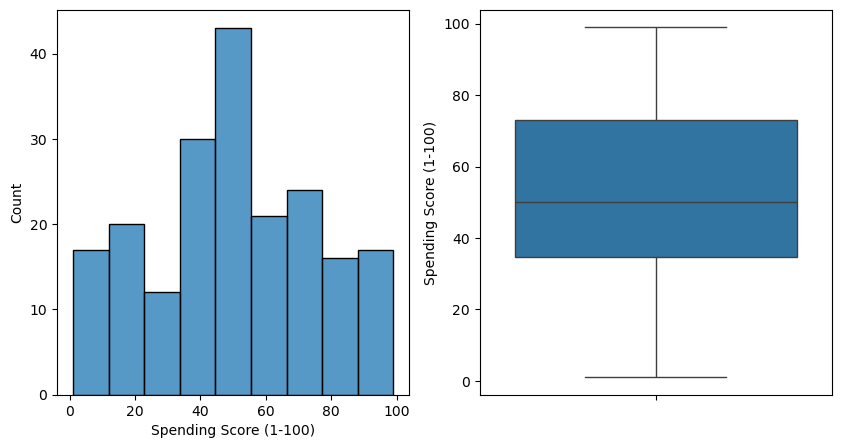

== Column name: Age
Median: 36.0
Mean: 38.85
Age doesn't follow normal distribution


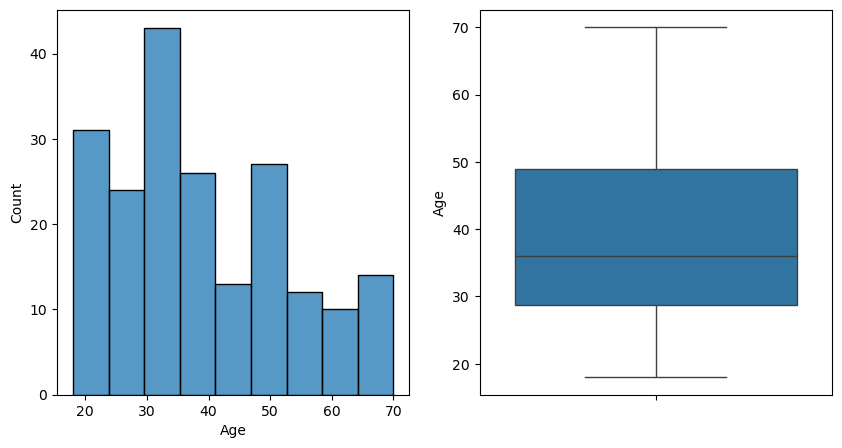

In [22]:
from scipy import stats

for col in num_cols:
    print(f'== Column name: {col}\nMedian: {X[col].median()}\nMean: {X[col].mean()}')
    statistics, p_value = stats.shapiro(X[col])
    if p_value < 0.05:
        print(f'{col} doesn\'t follow normal distribution')
    else:
        print(f'{col} follows normal distribution')

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.histplot(df, x=col)
    
    plt.subplot(1,2,2)
    sns.boxplot(data=df, y = col)
    plt.show()

<Axes: >

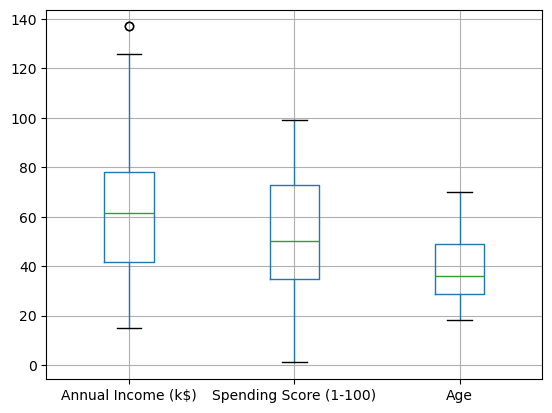

In [23]:
df[num_cols].boxplot()

Từ những kết quả trên, ta thấy:
1. Dữ liệu ko theo phân phối chuẩn
2. Dữ liệu có chút outliers
3. Range của các biến số khác nhau

=> Dùng RobustScaler để chuẩn hoá

In [24]:
from sklearn import preprocessing

scaler = preprocessing.RobustScaler()
X_scaler = scaler.fit_transform(X[['Annual Income (k$)', 'Spending Score (1-100)', 'Age']])

Kiểm tra biến phân loại (Gender)

<Axes: xlabel='Gender'>

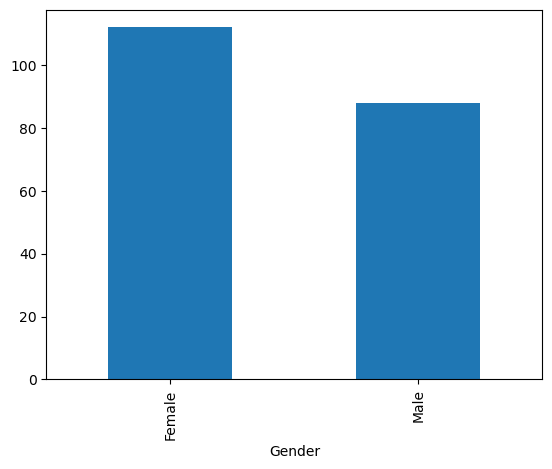

In [25]:
df['Gender'].value_counts().plot.bar()

Đối với biến phân loại (là biến Gender), dùng get_dummies để mã hoá => chỉ giữ lại cột Gender_Male

In [26]:
X = pd.get_dummies(X, drop_first=True)
X.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,19,15,39,True
1,21,15,81,True
2,20,16,6,False
3,23,16,77,False
4,31,17,40,False


Kết hợp data gốc & data scaled

In [27]:
X_sub = pd.DataFrame(X_scaler, columns=['Income_scaled', 'Spending_scaled', 'Age_scaled'])
data = pd.merge(X, X_sub, how = 'left', left_index=True, right_index=True)
data.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male,Income_scaled,Spending_scaled,Age_scaled
0,19,15,39,True,-1.273973,-0.287582,-0.839506
1,21,15,81,True,-1.273973,0.810458,-0.740741
2,20,16,6,False,-1.246575,-1.150327,-0.790123
3,23,16,77,False,-1.246575,0.705882,-0.641975
4,31,17,40,False,-1.219178,-0.261438,-0.246914


### Dùng scatter chart để trực quan hoá dữ liệu với một vài biến số

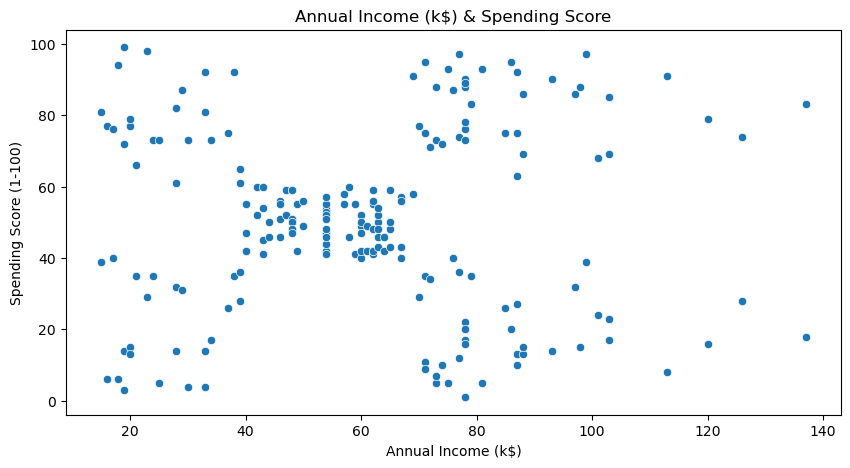

In [28]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=data, x = 'Annual Income (k$)', y = 'Spending Score (1-100)')
plt.title('Annual Income (k$) & Spending Score')
plt.show()

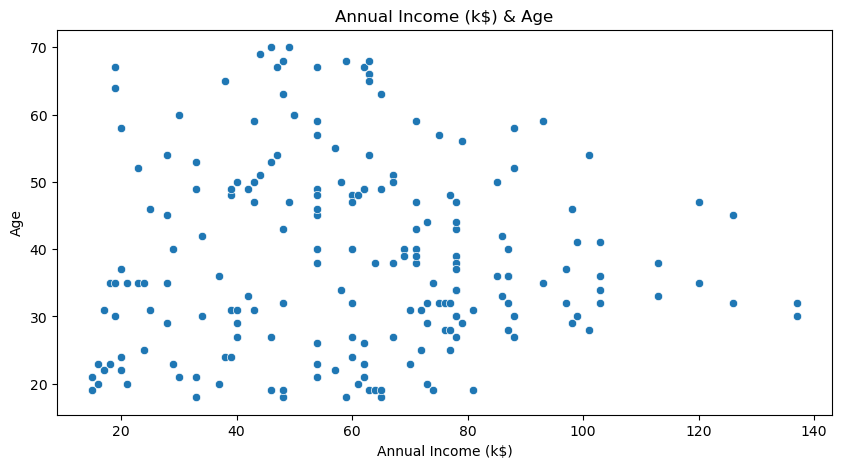

In [29]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=data, x = 'Annual Income (k$)', y = 'Age')
plt.title('Annual Income (k$) & Age')
plt.show()

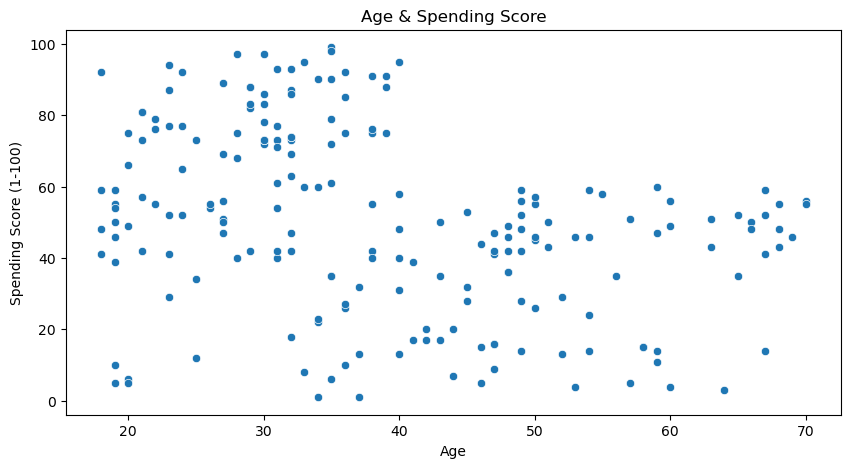

In [30]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=data, x = 'Age', y = 'Spending Score (1-100)')
plt.title('Age & Spending Score')
plt.show()

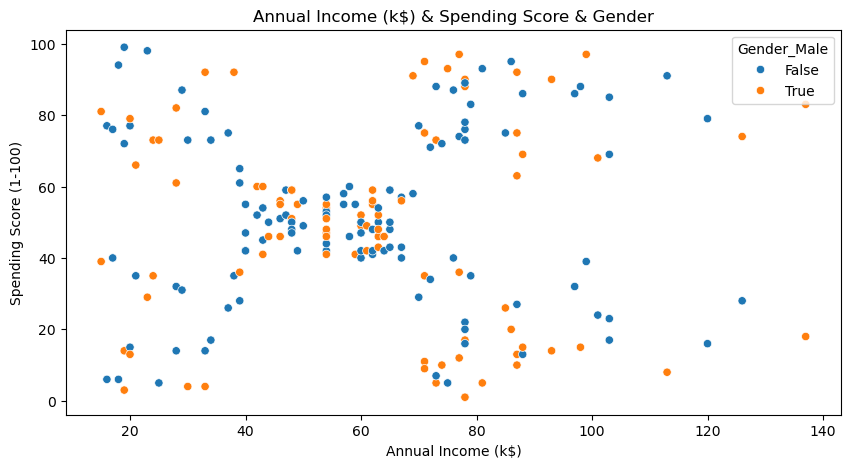

In [31]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=data, x = 'Annual Income (k$)', y = 'Spending Score (1-100)', hue = 'Gender_Male')
plt.title('Annual Income (k$) & Spending Score & Gender')
plt.show()

# 4. Phân cụm

Trong bài toán này, sẽ sử dụng inputs là Income_scaled, Spending_scaled, Age_scaled, Gender_Male

In [32]:
data.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male,Income_scaled,Spending_scaled,Age_scaled
0,19,15,39,True,-1.273973,-0.287582,-0.839506
1,21,15,81,True,-1.273973,0.810458,-0.740741
2,20,16,6,False,-1.246575,-1.150327,-0.790123
3,23,16,77,False,-1.246575,0.705882,-0.641975
4,31,17,40,False,-1.219178,-0.261438,-0.246914


Kiểm tra xem dimensions nào phù hợp để phân cụm

In [33]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

data['Gender_Male'] = np.where(data['Gender_Male'] == True, 1,0)

# xét thử các dimensions
X1 = data[['Income_scaled', 'Spending_scaled', 'Age_scaled', 'Gender_Male']]
X2 = data[['Spending_scaled', 'Age_scaled', 'Gender_Male']]
X3 = data[['Income_scaled', 'Age_scaled', 'Gender_Male']]
X4 = data[['Income_scaled', 'Spending_scaled', 'Gender_Male']]
X5 = data[['Income_scaled', 'Spending_scaled', 'Age_scaled']]


In [34]:
def compute_distortions(X, K):
    distortions = []
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    return distortions

/var/folders/83/8kx9n5vn35j3wwksdcw8t5qm0000gn/T/ipykernel_2593/3510373307.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, compute_distortions(X1,K), 'bx-', color='blue', label = 'X1 [[Income, Spending_score, Age, Gender_Male]]' )
/var/folders/83/8kx9n5vn35j3wwksdcw8t5qm0000gn/T/ipykernel_2593/3510373307.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, compute_distortions(X2,K), 'bx-', color='red', label = 'X2 [[Spending_score, Age, Gender_Male]]' )
/var/folders/83/8kx9n5vn35j3wwksdcw8t5qm0000gn/T/ipykernel_2593/3510373307.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, compute_distortions(X3,K), 'bx-', 

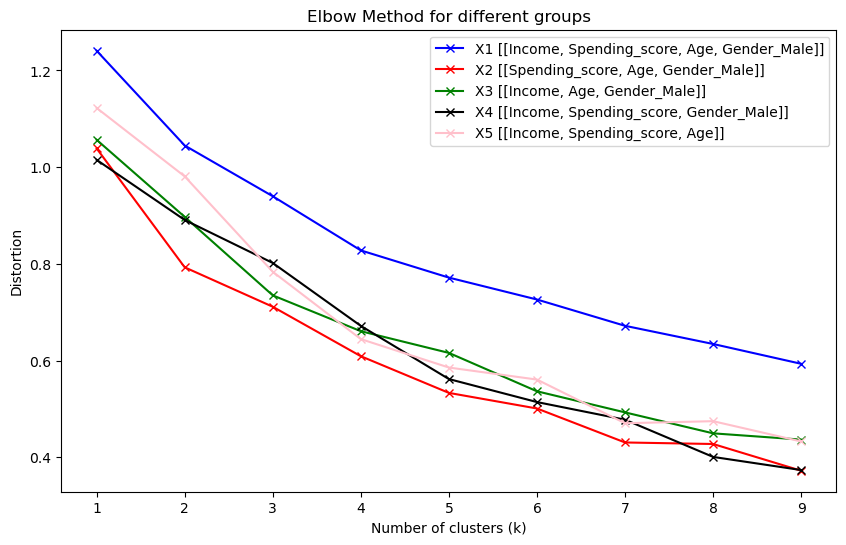

In [35]:
K = range(1, 10)

plt.figure(figsize=(10, 6))
plt.plot(K, compute_distortions(X1,K), 'bx-', color='blue', label = 'X1 [[Income, Spending_score, Age, Gender_Male]]' )
plt.plot(K, compute_distortions(X2,K), 'bx-', color='red', label = 'X2 [[Spending_score, Age, Gender_Male]]' )
plt.plot(K, compute_distortions(X3,K), 'bx-', color='green', label = 'X3 [[Income, Age, Gender_Male]]' )
plt.plot(K, compute_distortions(X4,K), 'bx-', color='black', label = 'X4 [[Income, Spending_score, Gender_Male]]')
plt.plot(K, compute_distortions(X5,K), 'bx-', color='pink', label = 'X5 [[Income, Spending_score, Age]]')

plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method for different groups')
plt.legend()
plt.show()

Ta Chọn dimension X5 bao gồm Income, Spending Score & Age (X5) và k=4 vì từ 4 ta thấy lỗi nhỏ và mịn dần

In [36]:
kmeanModel = KMeans(n_clusters=4)
kmeanModel.fit(X5)
centroids = kmeanModel.cluster_centers_
labels = kmeanModel.labels_

print('Centroids in RobustScaler\n',centroids )
print('Label\n', labels)

Centroids in RobustScaler
 [[-0.5890411   0.26923518 -0.52155079]
 [-0.37787144 -0.26224233  0.88812915]
 [ 0.6739726   0.82418301 -0.15432099]
 [ 0.68493151 -0.79532164  0.16634178]]
Label
 [0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1
 1 0 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1
 0 3 0 0 0 1 1 1 1 0 3 2 2 3 2 3 2 1 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2
 3 2 3 2 3 2 3 2 3 2 3 2 1 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3
 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2]


Group_1 là nhóm được phân loại dựa trên 3 biến Annual Income (k$), Spending Score (1-100), Age

In [37]:
data['group_1'] = pd.Series(labels)

In [38]:
data['group_1'].value_counts()

group_1
1    65
0    57
2    40
3    38
Name: count, dtype: int64

Vẽ biểu đồ phân cụm 3D

Text(0.5, 0, 'Age')

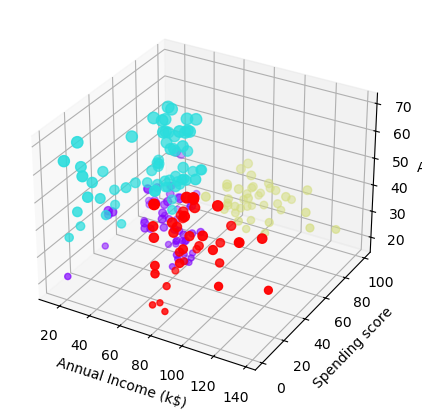

In [39]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111, projection ='3d')
ax.scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'], data['Age'],
           cmap = 'rainbow',
           s= data['Age'],
           c=data['group_1'])

ax.set_xlabel('Annual Income (k$)')
ax.set_ylabel('Spending score')
ax.set_zlabel('Age')

In [72]:
group1 = data.groupby('group_1').agg(total = ('Age', 'count'),
                    age_avg = ('Age', 'mean'),
                    income_avg = ('Annual Income (k$)', 'mean'),
                    spend_avg = ('Spending Score (1-100)', 'mean'),
                    gender_avg = ('Gender_Male', 'mean')
                    )
group1['Customer_type'] = ['3)Growth Opportunity', '4)Maintain and Retain', '1)High-Value Target', '2)Low Priority']
group1

,total,age_avg,income_avg,spend_avg,gender_avg,Customer_type
group_1,,,,,,
0,57,25.438596,40.000000,60.298246,0.403509,3)Growth Opportunity
1,65,53.984615,47.707692,39.969231,0.430769,4)Maintain and Retain
2,40,32.875000,86.100000,81.525000,0.450000,1)High-Value Target
3,38,39.368421,86.500000,19.578947,0.500000,2)Low Priority


1. Nhóm 1-High-Value Target: Độ tuổi trung bình, thu nhập cao, mức độ chi tiêu cao
2. Nhóm 2-Low Priority: Độ tuổi trung bình, thu nhập cao, mức độ chi tiêu thấp
3. Nhóm 3-Growth Opportunity: Độ tuổi trẻ, thu nhập thấp nhưng mức độ chi tiêu cao
4. Nhóm 4-Maintain and Retain: Khá Lớn tuổi, thu nhập trung bình, chi tiêu trung bình

# 5. PCA

## Áp dụng giảm chiều dữ liệu cho cả 4 dimensions

In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(X1)

PCA(n_components=2)

In [41]:
x_pca = pca.transform(X1)

In [42]:
print(x_pca.shape)

(200, 2)


In [43]:
df_pca = pd.DataFrame(x_pca,columns = ['pca1', 'pca2'])

In [44]:
df_pca.head()

,pca1,pca2
0,-0.396602,-1.222923
1,-1.071812,-1.263034
2,0.151609,-1.239214
3,-1.003489,-1.307731
4,-0.059971,-1.226931


## Xác định K

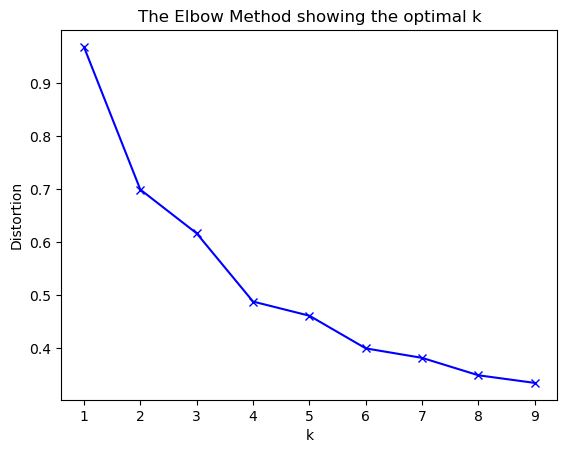

In [45]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans


K = range(1,10)
distortions = []

for k in K:
     kmeanModel = KMeans(n_clusters=k)
     kmeanModel.fit(df_pca)
     distortions.append(sum(np.min(cdist(df_pca, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_pca.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Ta chọn k = 4

In [46]:
kmeanModel = KMeans(n_clusters=4)
kmeanModel.fit(df_pca)
centroids = kmeanModel.cluster_centers_
labels = kmeanModel.labels_

print('Centroids in RobustScaler\n',centroids )
print('Label\n', labels)

Centroids in RobustScaler
 [[-0.70144182  0.44456028]
 [ 0.62963015  0.58895101]
 [-0.74699895 -0.82537372]
 [ 0.72335255 -0.50329405]]
Label
 [2 2 3 2 2 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3
 2 3 2 3 2 3 2 3 2 3 2 2 2 3 2 2 3 3 3 3 3 2 3 3 2 3 3 3 2 3 3 2 2 3 3 3 3
 3 0 3 3 2 3 3 0 3 3 2 3 3 0 0 3 3 0 1 3 0 0 3 0 1 0 0 1 1 0 1 0 1 1 1 1 1
 0 1 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]


Group_2 là phân cụm dựa vào các biến đã giảm chiều dữ liệu

In [47]:
# thêm label vào df_pca
df_pca['group_2'] = pd.Series(labels)

In [48]:
df_pca.head()

,pca1,pca2,group_2
0,-0.396602,-1.222923,2
1,-1.071812,-1.263034,2
2,0.151609,-1.239214,3
3,-1.003489,-1.307731,2
4,-0.059971,-1.226931,2


In [49]:
data = pd.merge(data, df_pca, how='left', left_index=True, right_index=True)
data.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male,Income_scaled,Spending_scaled,Age_scaled,group_1,pca1,pca2,group_2
0,19,15,39,1,-1.273973,-0.287582,-0.839506,0,-0.396602,-1.222923,2
1,21,15,81,1,-1.273973,0.810458,-0.740741,0,-1.071812,-1.263034,2
2,20,16,6,0,-1.246575,-1.150327,-0.790123,0,0.151609,-1.239214,3
3,23,16,77,0,-1.246575,0.705882,-0.641975,0,-1.003489,-1.307731,2
4,31,17,40,0,-1.219178,-0.261438,-0.246914,0,-0.059971,-1.226931,2


In [50]:
print(pca.explained_variance_ratio_)

[0.36599287 0.30581269]


In [51]:
vects = pca.components_[0:2] #pca1 & pca2
print(vects)

[[-0.06070358 -0.68029389  0.72677072  0.07293571]
 [ 0.9952901  -0.03992469  0.03774491  0.07986836]]


In [52]:
pca1 = pd.Series(vects[0], index = X1.columns)
pca2 = pd.Series(vects[1], index = X1.columns)

Kiểm tra thành phần của pca1 & pca2

In [53]:
pca1.sort_values(ascending=False)
pca1 = pd.Series(vects[0], index = X1.columns)
pca1

Income_scaled     -0.060704
Spending_scaled   -0.680294
Age_scaled         0.726771
Gender_Male        0.072936
dtype: float64

In [54]:
pca2.sort_values(ascending=False)
pca2 = pd.Series(vects[1], index = X1.columns)
pca2

Income_scaled      0.995290
Spending_scaled   -0.039925
Age_scaled         0.037745
Gender_Male        0.079868
dtype: float64

- Ta thấy pca1 được xây dựng chủ yếu dựa vào: Spending score & Age
- Và pca2 được xây dựng chủ yếu dựa trên: Income
- Biến Gender không chiếm nhiều thành phần trong pca1 và pca2


## Vẽ biểu đồ phân cụm

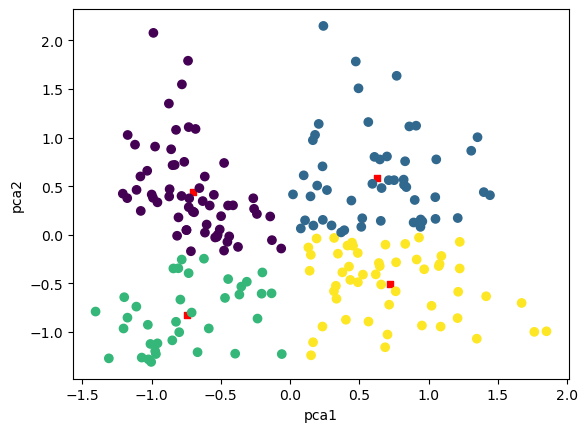

In [55]:
plt.scatter(centroids[:, 0],centroids[:, 1], marker = "s", s=15, color='red')
plt.scatter(df_pca['pca1'], df_pca['pca2'], c=df_pca['group_2'], cmap='viridis')
plt.xlabel('pca1')
plt.ylabel('pca2')
plt.show()

In [56]:
data.groupby('group_2').agg(pca1_avg = ('pca1', 'mean'),
                    pca2_avg = ('pca2', 'mean'),
                    )

,pca1_avg,pca2_avg
group_2,,
0,-0.701442,0.444560
1,0.629630,0.588951
2,-0.746999,-0.825374
3,0.723353,-0.503294


So sánh dữ liệu của 2 cách phân loại
- group1: phân loại dựa trên 3 biến Annual Income (k$), Spending Score (1-100), Age
- group2: phân cụm dựa vào các biến đã giảm chiều dữ liệu

In [70]:
group2 = data.groupby('group_2').agg(total = ('Age', 'count'),
                    age_avg = ('Age', 'mean'),
                    income_avg = ('Annual Income (k$)', 'mean'),
                    spend_avg = ('Spending Score (1-100)', 'mean'),
                    gender_avg = ('Gender_Male', 'mean')
                    )
group2['Customer_type'] = ['1)High-Value Target', '2)Low Priority', '3)Growth Opportunity', '4)Maintain and Retain']
group2

,total,age_avg,income_avg,spend_avg,gender_avg,Customer_type
group_2,,,,,,
0,60,30.066667,78.250000,70.233333,0.433333,1)High-Value Target
1,51,45.647059,80.490196,27.098039,0.549020,2)Low Priority
2,37,25.594595,32.054054,67.864865,0.378378,3)Growth Opportunity
3,52,51.750000,40.884615,37.173077,0.384615,4)Maintain and Retain


In [71]:
group1 = data.groupby('group_1').agg(total = ('Age', 'count'),
                    age_avg = ('Age', 'mean'),
                    income_avg = ('Annual Income (k$)', 'mean'),
                    spend_avg = ('Spending Score (1-100)', 'mean'),
                    gender_avg = ('Gender_Male', 'mean')
                    )
group1['Customer_type'] = ['3)Growth Opportunity', '4)Maintain and Retain', '1)High-Value Target', '2)Low Priority']
group1

,total,age_avg,income_avg,spend_avg,gender_avg,Customer_type
group_1,,,,,,
0,57,25.438596,40.000000,60.298246,0.403509,3)Growth Opportunity
1,65,53.984615,47.707692,39.969231,0.430769,4)Maintain and Retain
2,40,32.875000,86.100000,81.525000,0.450000,1)High-Value Target
3,38,39.368421,86.500000,19.578947,0.500000,2)Low Priority


Dựa vào dữ liệu, ta thấy 2 groups đều đưa phân các cụm tương tự nhau
1. Nhóm 1-High-Value Target: Độ tuổi trung bình, thu nhập cao, mức độ chi tiêu cao
2. Nhóm 2-Low Priority: Độ tuổi trung bình, thu nhập cao, mức độ chi tiêu thấp
3. Nhóm 3-Growth Opportunity: Độ tuổi trẻ, thu nhập thấp nhưng mức độ chi tiêu cao
4. Nhóm 4-Maintain and Retain: Khá Lớn tuổi, thu nhập trung bình, chi tiêu trung bình

=> Ta có thể đưa ra chiến dịch quảng cáo, chăm sóc khách hàng phù hợp cho mỗi nhóm